# Regression

In [57]:
%matplotlib inline
import matplotlib
matplotlib.use('TkAgg')
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn import linear_model

C:\Users\srotc_000\Anaconda3\lib\site-packages\matplotlib\__init__.py:1350: UserWarning:  This call to matplotlib.use() has no effect
because the backend has already been chosen;
matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


In [5]:
def normale(z, m, sigma):
    """ Loi normale, z sachant m et sigma"""
    return np.exp(-(z-m)**2/(2*sigma))/np.sqrt(2*np.pi*sigma)

In [62]:
class Regression:
    """Classe qui encapsule l'apprentissage"""
    
    def __init__(self, D, R):
        """Constructeur"""
        
        self.D = D #Nombre de variables explicatives
        self.R = R #Nombre d'annotateurs
     
    
    def chargeData(self, path, recentrage = True):
        """Fonction qui charge les données avec path le chemin du fichier CSV. 
        Par défault, on impose un recentrage des donnée"""
        
        data = pd.read_csv(path, delimiter = ";")
        self.trueLabel = np.array(data.ix[:,self.D])
        self.y = np.array(data.ix[:,self.D+1:]) #labels des annotateurs
        x = np.array(data.ix[:,0:self.D]) #variables explicatives
        if (recentrage):
            self.x = (x -np.mean(x,axis=0))/(np.std(x, axis=0))
        else:
            self.x = x
        self.N = self.y.shape[0] #Nombre de lignes
     
    
    def initw(self):
        """Initialisation de w"""

        self.w = np.random.random_sample((self.D,))
    
    
    def update_lambda(self):
        """Update du vecteur lambda (Rx1)"""
        
        lambd = []
        for j in range(0,self.R):
            tmp = 0
            for i in range(0,self.N):
                tmp += (self.y[i][j] - self.w.T.dot(self.x[i]))**2
            tmp = tmp/self.N
            lambd.append(1/tmp)
        self.lambd = np.array(lambd)
    
    
    def update_w(self):
        """Update du vecteur w (Nx1)"""
        
        w = 0
        tmp = 0
        for i in range(0,self.N):
            tmp += self.x[i].dot(self.x[i].T)
            tmp2 = 0
            for j in range(0,self.R):
                tmp2 += self.lambd[j]*self.y[i][j]
            w += self.x[i]*tmp2/(np.sum(self.lambd))
        self.w = self.w/tmp
       
    
   
    def logLikelihood(self):
        """Calcul de la log-vraissemblance."""
    
        #On calcule directement la log-vraissemblance.
        vraissemblance = 0
        for i in range(0,self.N):
            for j in range(0,self.R):
                vraissemblance += np.log(normale(self.y[i][j],self.w.T.dot(self.x[i]),1/self.lambd[j]))
        return vraissemblance
    

   
    def score(self, seuil = 1/2):
        """Quel est le score d'apprentissage de notre modèle ?"""
        return np.mean(np.equal(self.trueLabel, np.array(self.w.dot(self.x.T))>seuil))
        
        
    def pred_labels(self):
        #Label prédit par le modèle
        #self.labels_predits = np.random.normal(self.w.T.dot(self.x),1/self.lambd[j])
        self.labels_predits = self.x.dot(self.w)
        
    
    def train(self, maxIter = 1000, minIter = 200, epsilon = 0.01, graphe=True):
        """Fonction qui lance l'entrainement du modèle.
        La variable graphe sert à plotter la log-likelihood au fil des itérations.
        La log-likelihood devrait être croissante."""
        
        self.maxIter = maxIter
        
        self.initw()

        compteur = 0
        self.histLogLikelihood = []

        while (compteur < maxIter):
            self.update_lambda()
            wOld = self.w
            self.update_w()
            wNew = self.w
            self.histLogLikelihood.append(self.logLikelihood())
            diffW = wOld - wNew
            if (np.linalg.norm(diffW) < epsilon):
                print("SEUIL DE CONVERGENCE SUR W ATTEINT")
                print ("ITERATION : ", compteur)
                print("Vraissemblance : ", self.logLikelihood())
                print("Norme de diff_w : ", np.linalg.norm(diffW))
                print("Lambda : ", self.lambd)
                break
            
            if (compteur % 100 == 0):
                print ("ITERATION : ", compteur)
                print("Vraissemblance : ", self.logLikelihood())
                print("Norme de diff_w : ", np.linalg.norm(diffW))
                print("Lambda : ", self.lambd)
            compteur = compteur + 1
        
        if graphe:
            plt.plot(self.histLogLikelihood)
            plt.title('Log-vraissemblance au fil des itérations')
       
    
    def linearRegression(self):
        """On entraine avec sklearn un modèle de régression linéaire sur les données."""
        
        self.regr = linear_model.LinearRegression()
        self.regr.fit(self.x, self.trueLabel)
        print('Coefficients: \n', regr.coef_)

ITERATION :  0
Vraissemblance :  -48488.7583085
Norme de diff_w :  1.86446121802
Lambda :  [ 0.01064981  0.01433536  0.01492962]
SEUIL DE CONVERGENCE SUR W ATTEINT
ITERATION :  3
Vraissemblance :  -47734.431207
Norme de diff_w :  6.02233617354e-13
Lambda :  [ 0.00729328  0.00888601  0.00911226]


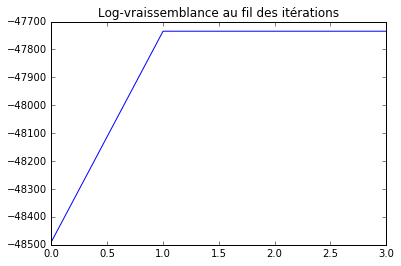

In [63]:
abalone = Regression(8, 3)
abalone.chargeData('Datasets/Abalone/Abalone_Reg.csv', recentrage=False)
abalone.train(maxIter = 500, epsilon = 1e-10, graphe = True)

In [64]:
abalone.pred_labels()
abalone.labels_predits

array([  4.82738464e-17,   3.63910206e-17,   4.48550793e-17, ...,
         7.48117317e-17,   6.17781943e-17,   1.01735829e-16])

In [65]:
abalone.linearRegression()

Coefficients: 
 [  0.3884832   -0.82639908  11.96403178  11.20449196   9.07020864
 -20.10614364 -10.15510106   8.70110596]


In [66]:
abalone.regr.score(abalone.x, abalone.trueLabel)

0.53534457649388245

In [67]:
abalone.regr.predict(abalone.x)

array([  9.2423098 ,   7.81022316,  10.84388028, ...,  11.10439683,
         9.51353803,  11.14402922])